---
# GRPN Take-Home Assignment
---

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from datetime import datetime

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 7))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

---
## Acquire Raw Data
---

In [116]:
df = pd.read_excel('GRPN_data.xlsx', sheet_name='Q4 2013 Raw Data', index_col=0)
df = df.drop(columns=['Unnamed: 6'])
df = df.reset_index().set_index('Start Date').sort_index()

In [125]:
df.tail(10)

,Deal ID,Units Sold,Gross Billings,Deal URL,Segment
Start Date,,,,,
2013-12-31,ga-bk-holiday-inn-express-times-square,13.050,1291.95000,http://www.groupon.com/deals/ga-bk-holiday-inn...,Travel
2013-12-31,the-original-pancake-house-6,216.100,2905.00000,http://www.groupon.com/deals/the-original-panc...,Local
2013-12-31,the-original-pancake-house-5,111.600,1488.00000,http://www.groupon.com/deals/the-original-panc...,Local
2013-12-31,ga-bk-the-commons-hotel,4.350,413.25000,http://www.groupon.com/deals/ga-bk-the-commons...,Travel
2013-12-31,excel-with-business-187-us-boise,2.900,200.10000,http://www.groupon.com/deals/excel-with-busine...,Local
2013-12-31,hollywood-fitness,0.000,0.00000,http://www.groupon.com/deals/hollywood-fitness,Local
2013-12-31,luxe-beauty-lounge-mobile-spa-2,5.800,469.80000,http://www.groupon.com/deals/luxe-beauty-loung...,Local
2013-12-31,dream-weaver-salon-day-spa-1,30.800,2218.00000,http://www.groupon.com/deals/dream-weaver-salo...,Local
2013-12-31,ga-vista-sol-buenos-aires-design,0.000,0.00000,http://www.groupon.com/deals/ga-vista-sol-buen...,Travel


In [118]:
df.shape

(138534, 5)

- Looks like we got all the rows from the raw data

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138534 entries, 2011-11-21 to 2013-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Deal ID         138534 non-null  object 
 1   Units Sold      138534 non-null  float64
 2   Gross Billings  138534 non-null  float64
 3   Deal URL        138534 non-null  object 
 4   Segment         138534 non-null  object 
dtypes: float64(2), object(3)
memory usage: 6.3+ MB


- Don't see any nulls in any columns

In [129]:
df.isna().sum()

Deal ID           0
Units Sold        0
Gross Billings    0
Deal URL          0
Segment           0
dtype: int64

In [120]:
df.describe()

,Units Sold,Gross Billings
count,138534.000000,1.385340e+05
mean,178.462592,5.500602e+03
std,864.551565,2.774653e+04
min,-9100.000000,-2.180629e+05
25%,1.450000,6.380000e+01
50%,19.200000,8.502000e+02
75%,99.200000,3.677450e+03
max,62500.000000,2.874885e+06


In [40]:
# take a look at date range for data
df.index.min(), df.index.max()

(Timestamp('2011-11-21 00:00:00'), Timestamp('2013-12-31 00:00:00'))

In [121]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)

Number of rows: 515
Number of days between first and last day: 772 days 00:00:00


- We are missing a lot of days

In [140]:
df.shape

(138534, 5)

In [148]:
df.resample('D').sum().head(10)

,Units Sold,Gross Billings
Start Date,,
2011-11-21,0.0,0.0
2011-11-22,0.0,0.0
2011-11-23,0.0,0.0
2011-11-24,0.0,0.0
2011-11-25,0.0,0.0
2011-11-26,0.0,0.0
2011-11-27,0.0,0.0
2011-11-28,0.0,0.0
2011-11-29,0.0,0.0


In [146]:
df.resample('D').sum().tail(10)

,Units Sold,Gross Billings
Start Date,,
2013-12-22,123535.164,3.683928e+06
2013-12-23,187513.496,6.410913e+06
2013-12-24,66734.150,1.727414e+06
2013-12-25,70529.836,1.798346e+06
2013-12-26,217267.764,5.891075e+06
2013-12-27,135330.742,3.548567e+06
2013-12-28,106305.084,2.837010e+06
2013-12-29,52808.318,1.397689e+06
2013-12-30,46946.726,1.192412e+06


In [133]:
df['Gross Billings'].head(20)

Start Date
2011-11-21       0.00
2011-11-21       0.00
2011-11-21       0.00
2011-11-21       0.00
2012-06-06    4253.20
2012-06-26     763.00
2012-06-26    8556.50
2012-07-01       0.00
2012-07-07       0.00
2012-07-21     261.60
2012-07-29     469.80
2012-07-31    1580.50
2012-08-01       0.00
2012-08-01     390.05
2012-08-04     534.10
2012-08-04     246.70
2012-08-04    1652.10
2012-08-08       0.00
2012-08-12     392.00
2012-08-14     392.40
Name: Gross Billings, dtype: float64

In [138]:
# lets upsample the data to make sure that we have an observation for each day (even if it is a null value)
# we will likely eventually want to do this for each segment, but I will see what happens for all data first (will likely be less accurate?)
# resample to daily first (looks like this is all that we actually need to do, this method inserts a row for each day and fills those with no values with a 0)
df['Gross Billings'].resample('D').sum().head(20)

Start Date
2011-11-21    0.0
2011-11-22    0.0
2011-11-23    0.0
2011-11-24    0.0
2011-11-25    0.0
2011-11-26    0.0
2011-11-27    0.0
2011-11-28    0.0
2011-11-29    0.0
2011-11-30    0.0
2011-12-01    0.0
2011-12-02    0.0
2011-12-03    0.0
2011-12-04    0.0
2011-12-05    0.0
2011-12-06    0.0
2011-12-07    0.0
2011-12-08    0.0
2011-12-09    0.0
2011-12-10    0.0
Freq: D, Name: Gross Billings, dtype: float64

In [169]:
# lets try to freq method and see how it handles empty values
# df.asfreq('D')
# this method doesn't work here since there are multiple rows for some days and no rows for others
# Since there are mutliple rows for some days, some aggregation must take place, and this method doesn't aggregate
# resample mehtod should be used instead

<AxesSubplot:xlabel='Start Date'>

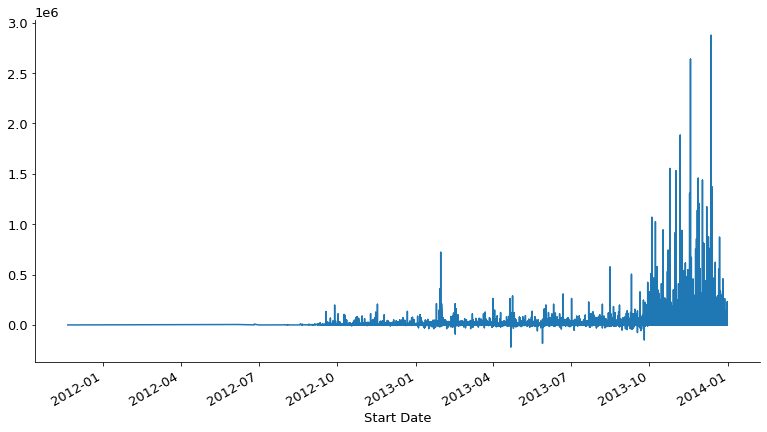

In [122]:
# lets take a look at all data in raw form
df['Gross Billings'].plot()

- Really don't have any data from 01/2021 to 10-2012
- Doesn't appear that any historical data present in this raw data will be useful in predicting missing data for quarter of interest

<AxesSubplot:xlabel='Start Date'>

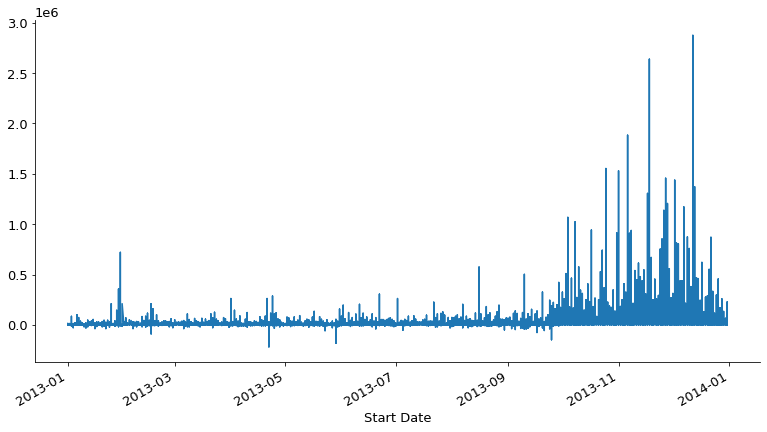

In [123]:
# lets take a look at just 2013 data
df['Gross Billings']['2013'].plot()

- Data from earlier in 2013 doesn't seem to be useful in filling in missing values
- Let's just focus on the quarter of interest from here on out

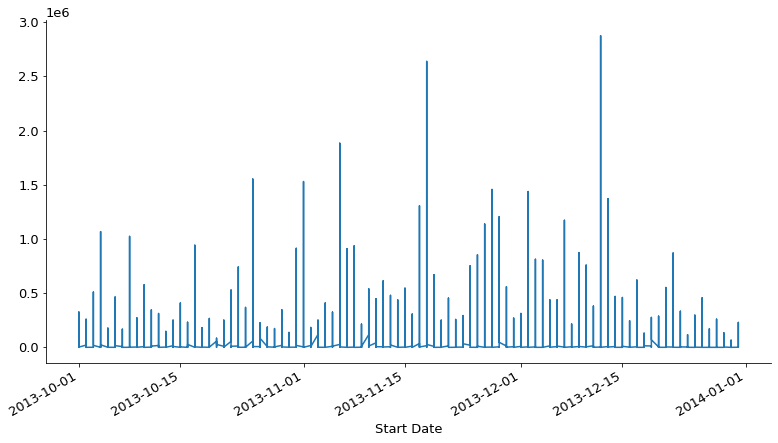

In [45]:
# lets look at subset for the quarter we are interested in predicting
# 4Q13 (the fourth quarter of 2013, or the time period from 10/1/13 - 12/31/13, inclusive).
df['Gross Billings']['2013-10' : '2013-12'].plot();

- Data is not really useful in raw form since it is not very interpretable.
- Why?
    - There are many entries on each day and days in between with no entries at all?
        - Let's create a column for the day of the year, groupby that column and see totals
            - This will help me to see if we are missing a bunch of days
            - I don't think we are missing days, but the fact that there are multiple entries per day must be messing up the plot??

In [159]:
# add a column with the day of the year for each row
df['day_of_year'] = df.index.dayofyear

In [176]:
# take a look and see if it worked properly
# it appears to have worked
df.day_of_year.value_counts()

330    1087
305    1083
357    1064
353    1059
344    1057
       ... 
2        61
5        60
9        57
7        54
366      51
Name: day_of_year, Length: 366, dtype: int64

In [183]:
# now take a look for the quarter of interest
df['2013-10' : '2013-12'].day_of_year.value_counts()

330    1032
305    1019
331     988
353     985
344     979
       ... 
294     132
300     131
293     130
296     125
299     121
Name: day_of_year, Length: 92, dtype: int64

- Looks like there are multiple entries for all days amongst all segments for the quarter of interest

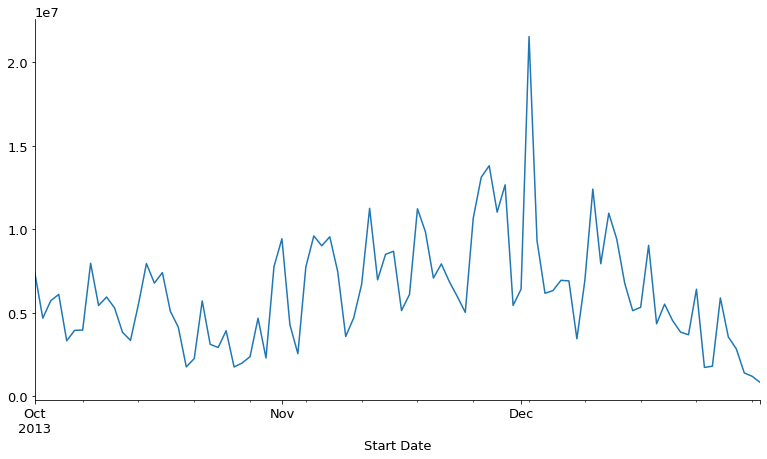

In [185]:
# resample by day and plot for quarter of interest
df['Gross Billings']['2013-10' : '2013-12'].resample('D').sum().plot();

- Not easy to see missing values here since we are looking at all segments

<AxesSubplot:xlabel='Start Date'>

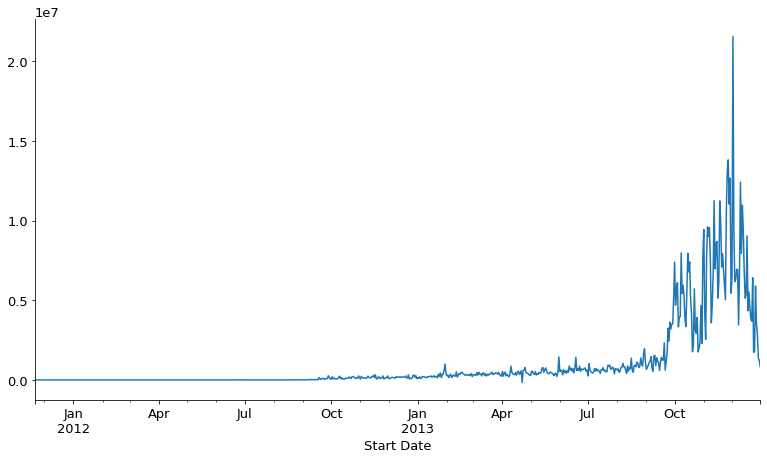

In [102]:
# resample by day and take the sum for all data
df['Gross Billings'].resample('D').sum().plot()

- I see the drop in gross billings around end of Oct 2013 (missing data?)

## Find Missing Data

In [54]:
# lets break down into each segment
df.Segment.value_counts()

Local     120576
Goods      15234
Travel      2724
Name: Segment, dtype: int64

In [58]:
local_df = df[df.Segment == 'Local']
goods_df = df[df.Segment == 'Goods']
travel_df = df[df.Segment == 'Travel']

### Local

<AxesSubplot:xlabel='Start Date'>

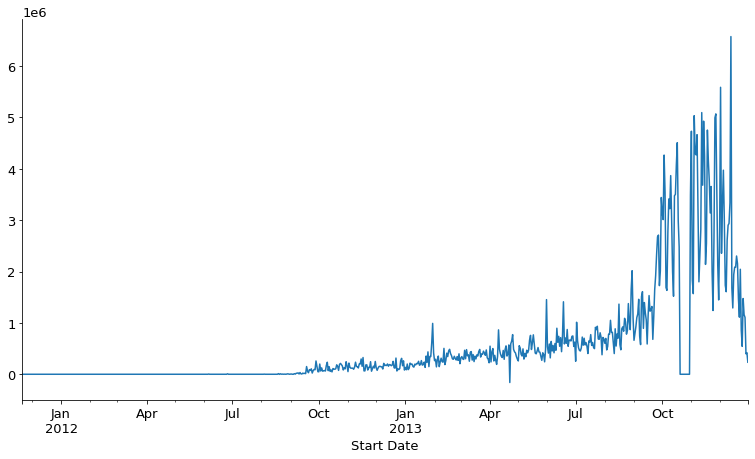

In [104]:
local_df['Gross Billings'].resample('D').sum().plot()

<AxesSubplot:xlabel='Start Date'>

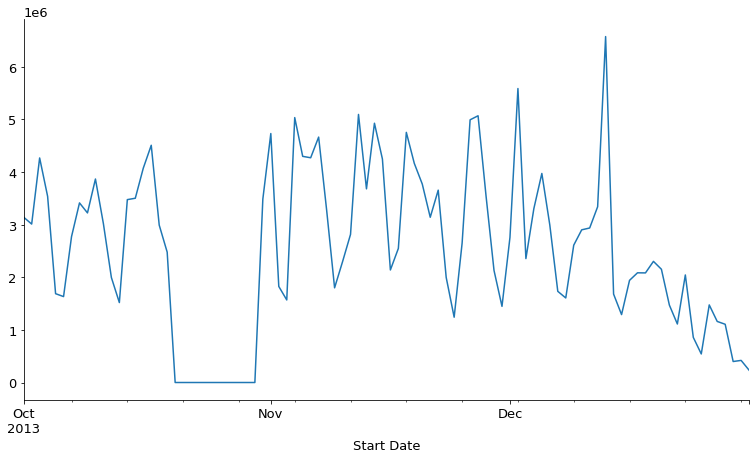

In [186]:
local_df['Gross Billings']['2013-10' : '2013-12'].resample('D').sum().plot()

- Looks like we are missing some data here toward the end of October
- We have some data going back to Oct 2012 but doesn't look representative of what we are seeing for 2013 (couldn't really be used to predict?)
- Need to figure out a way to fill the missing values here
    - forward fill?
    - back fill?
    - Might be able to use some seasonality and previous trends here to impute the missing data

In [198]:
local_df['Gross Billings']['2013-10' : '2013-12'].resample('D').sum().sum()

230376199.90699995

In [199]:
local_df['Gross Billings']['2013-10' : '2013-12'].sum()

230376199.907

<AxesSubplot:xlabel='Start Date'>

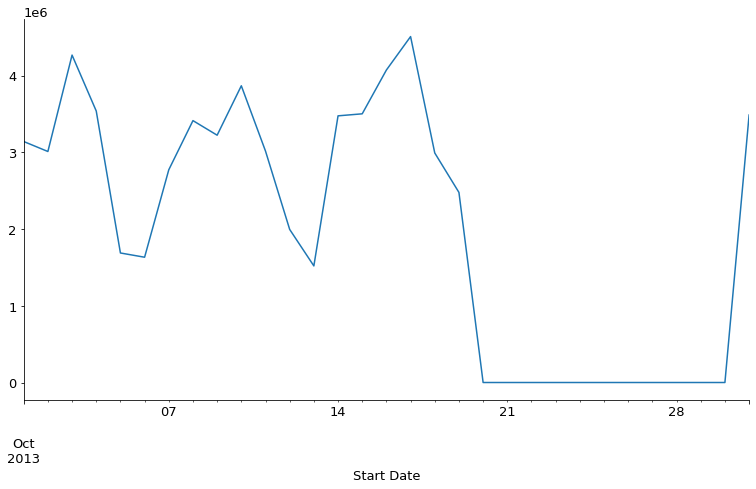

In [205]:
# take a closer look at where we have missing data
local_df['Gross Billings']['2013-10'].resample('D').sum().plot()

In [207]:
# take a closer look at where we have missing data
local_df['Gross Billings']['2013-10'].resample('D').sum()

Start Date
2013-10-01    3.140574e+06
2013-10-02    3.010398e+06
2013-10-03    4.266867e+06
2013-10-04    3.538083e+06
2013-10-05    1.687881e+06
2013-10-06    1.632563e+06
2013-10-07    2.771953e+06
2013-10-08    3.412731e+06
2013-10-09    3.222805e+06
2013-10-10    3.866735e+06
2013-10-11    3.015991e+06
2013-10-12    1.994842e+06
2013-10-13    1.519141e+06
2013-10-14    3.475041e+06
2013-10-15    3.501416e+06
2013-10-16    4.072212e+06
2013-10-17    4.507996e+06
2013-10-18    2.991175e+06
2013-10-19    2.477089e+06
2013-10-20    0.000000e+00
2013-10-21    0.000000e+00
2013-10-22    0.000000e+00
2013-10-23    0.000000e+00
2013-10-24    0.000000e+00
2013-10-25    0.000000e+00
2013-10-26    0.000000e+00
2013-10-27    0.000000e+00
2013-10-28    0.000000e+00
2013-10-29    0.000000e+00
2013-10-30    0.000000e+00
2013-10-31    3.485813e+06
Freq: D, Name: Gross Billings, dtype: float64

- We are missing data for 10-20 through 10-30

### Goods

<AxesSubplot:xlabel='Start Date'>

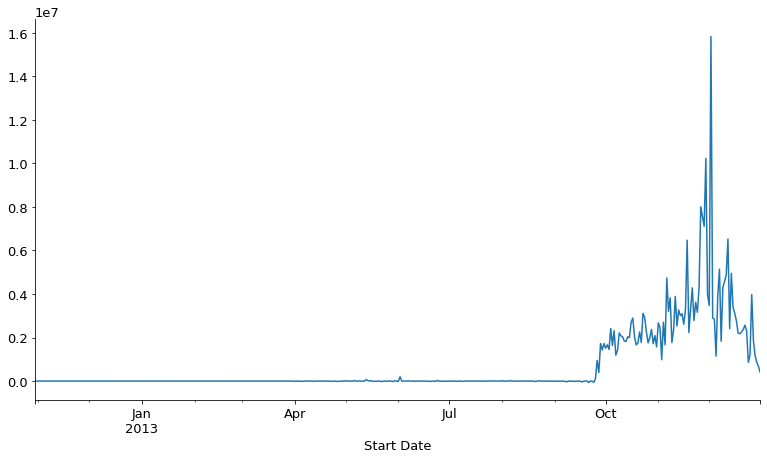

In [189]:
goods_df['Gross Billings'].resample('D').sum().plot()

<AxesSubplot:xlabel='Start Date'>

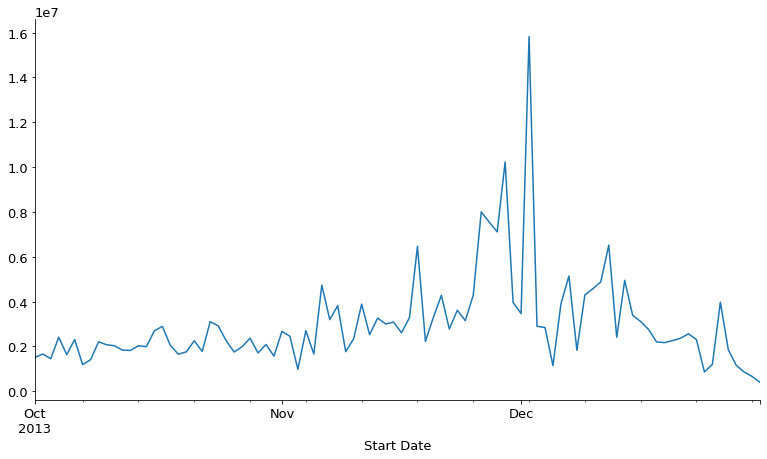

In [188]:
goods_df['Gross Billings']['2013-10' : '2013-12'].resample('D').sum().plot()

- Don't really have any data until Oct 2013
- No obvious areas of missing data
- Don't see any obvious trends to use to predict
    - Might not need to predict here if we aren't missing any data in this segment
- Just take the sum of all gross billings for this segment for the quarter of interest and see how that compares to consensus estimate

In [193]:
# Take the sum of all gross billings for quarter of interest and compare to consensus numbers
goods_df['Gross Billings']['2013-10' : '2013-12'].resample('D').sum().sum()

276264895.58344

In [195]:
# get sum without resampling to confirm that it is the same
goods_df['Gross Billings']['2013-10' : '2013-12'].sum()

276264895.58344007

### Travel

<AxesSubplot:xlabel='Start Date'>

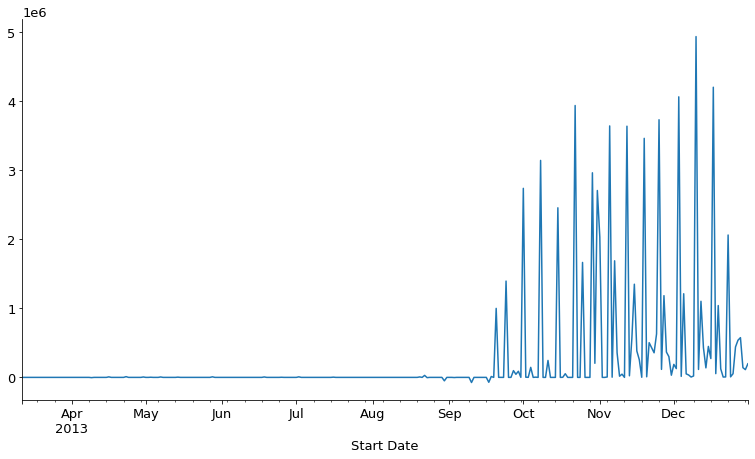

In [88]:
travel_df['Gross Billings'].resample('D').sum().plot()

<AxesSubplot:xlabel='Start Date'>

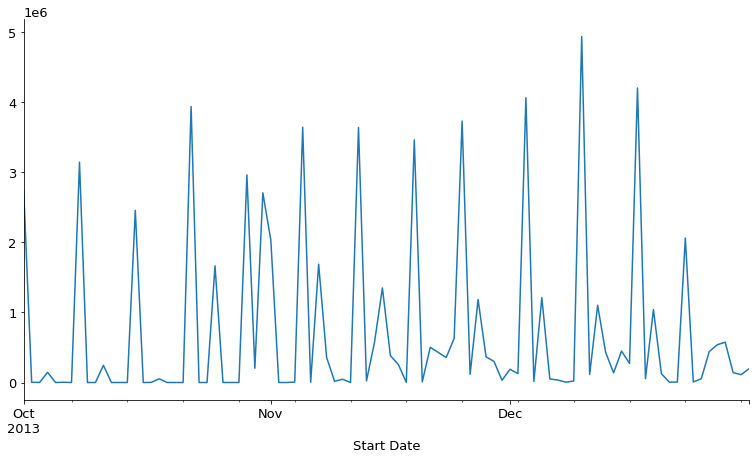

In [191]:
travel_df['Gross Billings']['2013-10' : '2013-12'].resample('D').sum().plot()

- This data seems much less consistent
    - Makes sense that there would be less activity since these are likely larger purchases
- How can I tell if we have missing data?
    - Take sum of given data and see if we are close to the estimates provided

In [196]:
travel_df['Gross Billings']['2013-10' : '2013-12'].resample('D').sum().sum()

68021541.26699999

In [197]:
travel_df['Gross Billings']['2013-10' : '2013-12'].sum()

68021541.267

In [1]:
# this is just a test of my github repo